In [3]:
import numpy as np
from numpy import *
import pylab as plt
from simple_pe import cosmology
import astropy.units as u
import astropy

import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d

from astropy.cosmology import Planck15 as cosmo, z_at_value

In [4]:
plt.rcParams.update({
    'figure.figsize': (15, 10),
    "lines.markersize": 6,
    "lines.markeredgewidth": 1.5,
    "lines.linewidth": 3.0,
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

# Basic cosmology

In [5]:
z=linspace(0,20,1000)

In [6]:
dc = cosmo.comoving_distance(z)
dl = cosmo.luminosity_distance(z)
t = cosmo.lookback_time(z)

In [7]:
data = [z, t, dc, dl]
label = ['Redshift (z)', 'Lookback time (Gyr)', 'Comoving Distance (Mpc)', 'Luminosity Distance (Mpc)']

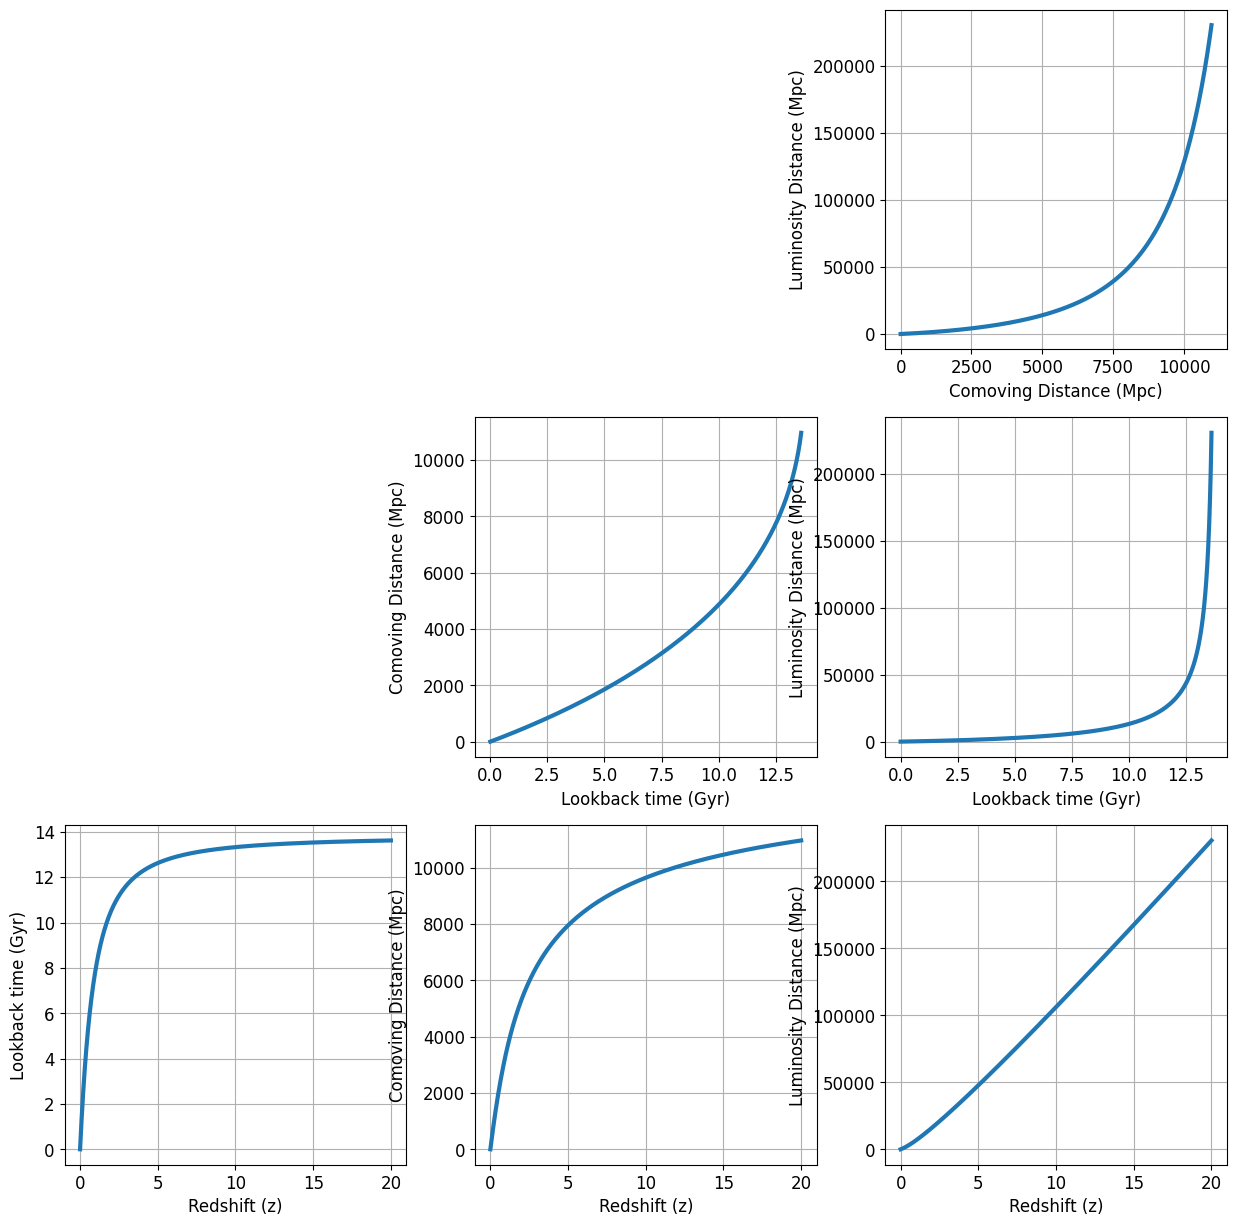

In [8]:
plt.figure(figsize=(15, 15))
for i, d1 in enumerate(data):
    for j, d2 in enumerate(data):
        if j > i:
            plt.subplot(3, 3, 3*(2-i) + j)
            plt.plot(d1, d2)
            plt.grid()
            plt.xlabel(label[i])
            plt.ylabel(label[j])


# Star formation rates

In [9]:
sfr = cosmology.sfrMD(z)

In [10]:
def simple_sfr(z):
    """
    Simple star formation model that is close to Madau Dickenson, but uses
    simple functions of lookback time

    :param z: Redshifts
    :type z: np.array, required
    """
    t = cosmo.lookback_time(z)
    sfr = np.zeros_like(z)

    t0 = 10.
    t1 = 11.7
    tlow = t.value < t0
    tmid = (t.value > t0) & (t.value < t1)
    thi = (t.value > t1)
    
    #sfr[tlow] = 0.014 * np.power(10, t.value[tlow]/10)    
    sfr[tlow] = 0.014 + (t.value[tlow]/10)**2 * 0.126 


    sfr[tmid] = np.ones_like(t.value)[tmid] * 0.14
    sfr[thi] = 0.14 * np.power(10, (t1 - t.value[thi]))

    return sfr

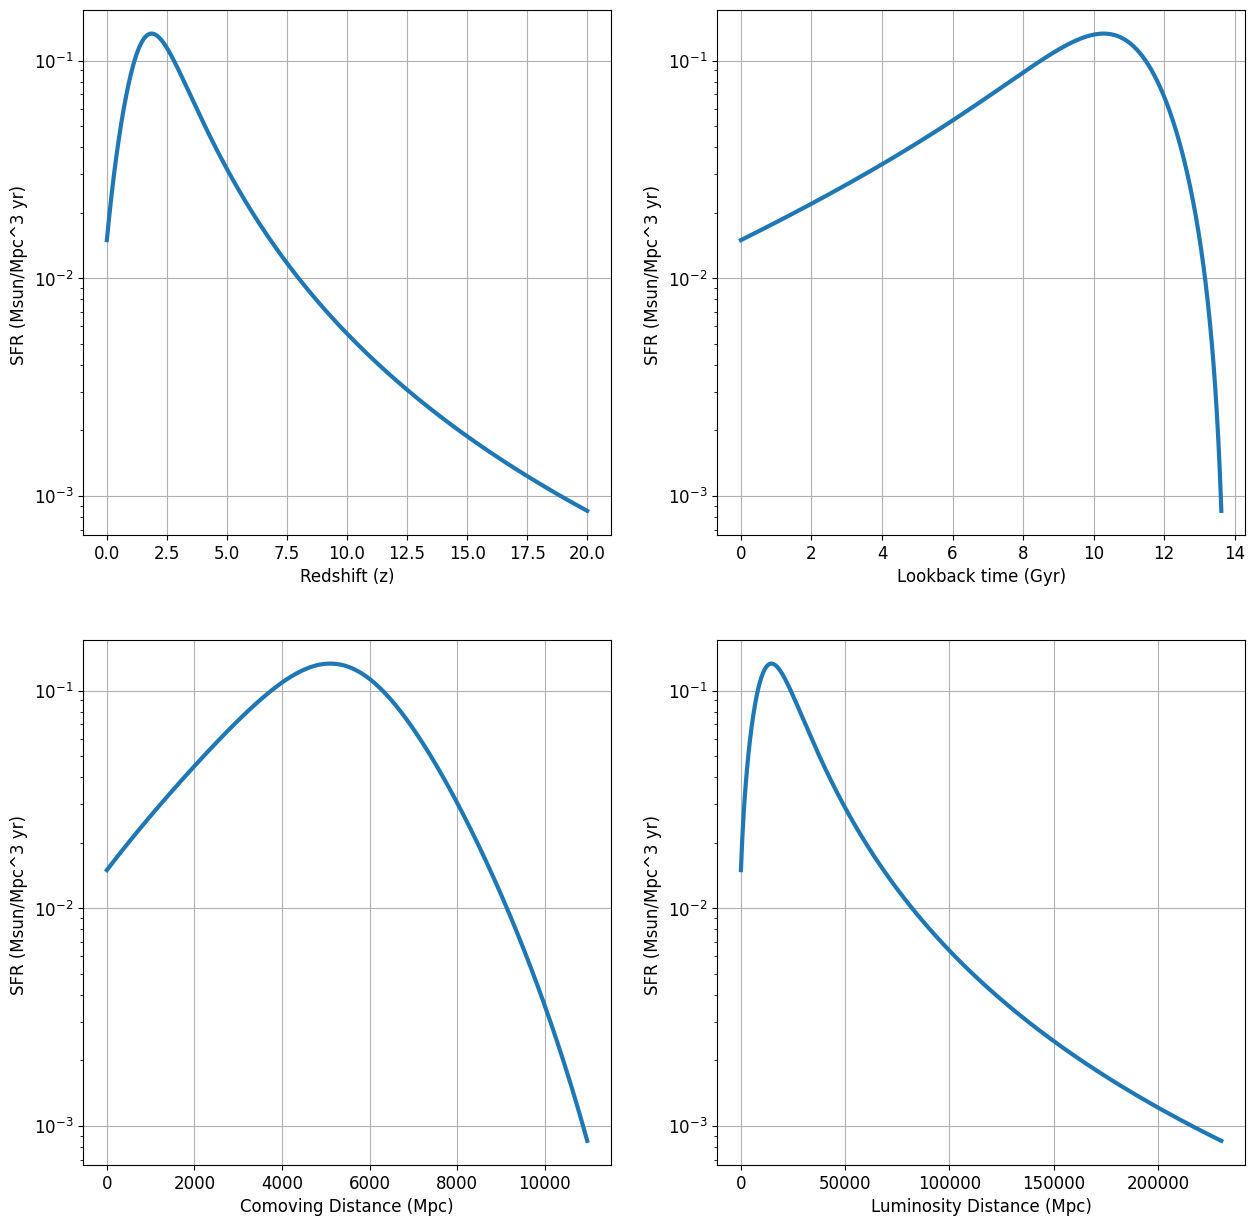

In [11]:
plt.figure(figsize=(15, 15))
for i, d in enumerate(data):
    plt.subplot(2, 2, i+1)
    plt.semilogy(d, sfr)
    plt.ylabel("SFR (Msun/Mpc^3 yr) ")
    plt.xlabel(label[i])
    plt.grid()

# Convolution integral to get the CBC merger history

Time delay distribution modelled at 1/t

In [12]:
delay = cosmology.delay_distribution(t[1:])

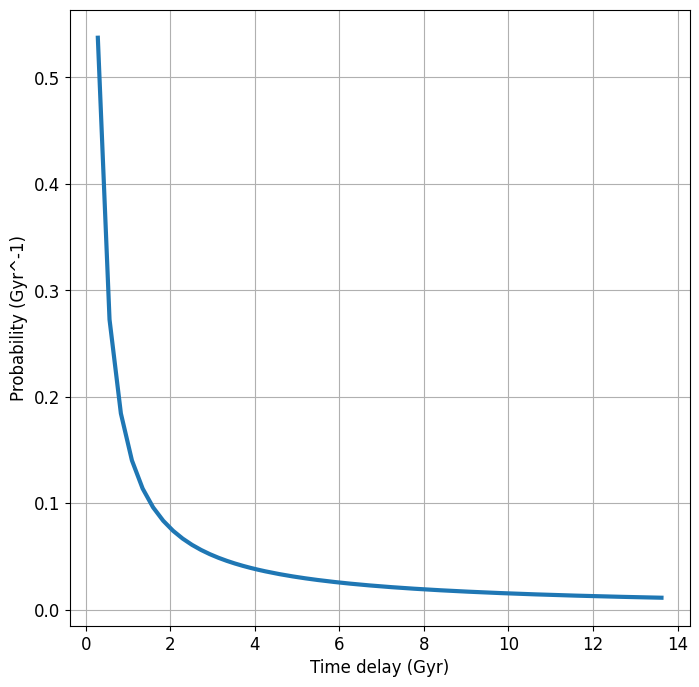

In [13]:
plt.figure(figsize=(8,8))
plt.plot(t[1:], delay)
plt.xlabel('Time delay (Gyr)')
plt.ylabel('Probability (Gyr^-1)')
plt.grid()

# Formation of a binary merging at fixed z

In [14]:
t_min = cosmology.age_at_redshift(20)
z0 = 0.5
t0 = cosmology.age_at_redshift(z0)

In [15]:
ts = np.linspace(t_min, t0 - 0.001, 100)

In [16]:
rdi = cosmology.rate_density_integrand(ts, t0, sfr = cosmology.sfrMD)

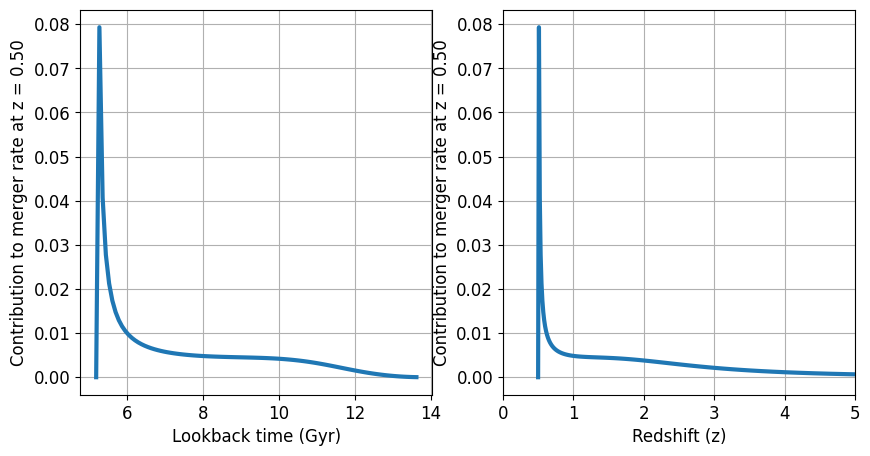

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cosmology.age_at_redshift(0) - ts, rdi)
plt.xlabel('Lookback time (Gyr)')
plt.ylabel('Contribution to merger rate at z = %.2f' % z0)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(cosmology.redshift_at_age(ts), rdi)
plt.xlabel('Redshift (z)')
plt.ylabel('Contribution to merger rate at z = %.2f' % z0)
plt.xlim(0, 5)
plt.grid()

## Merger rate accounting for time delay

In [18]:
mrd = np.zeros_like(z)
for i, zz in enumerate(z):
    mrd[i] = cosmology.rate_density(zz, sfr= cosmology.sfrMD)
    

In [20]:
omrd = mrd/(1+z)

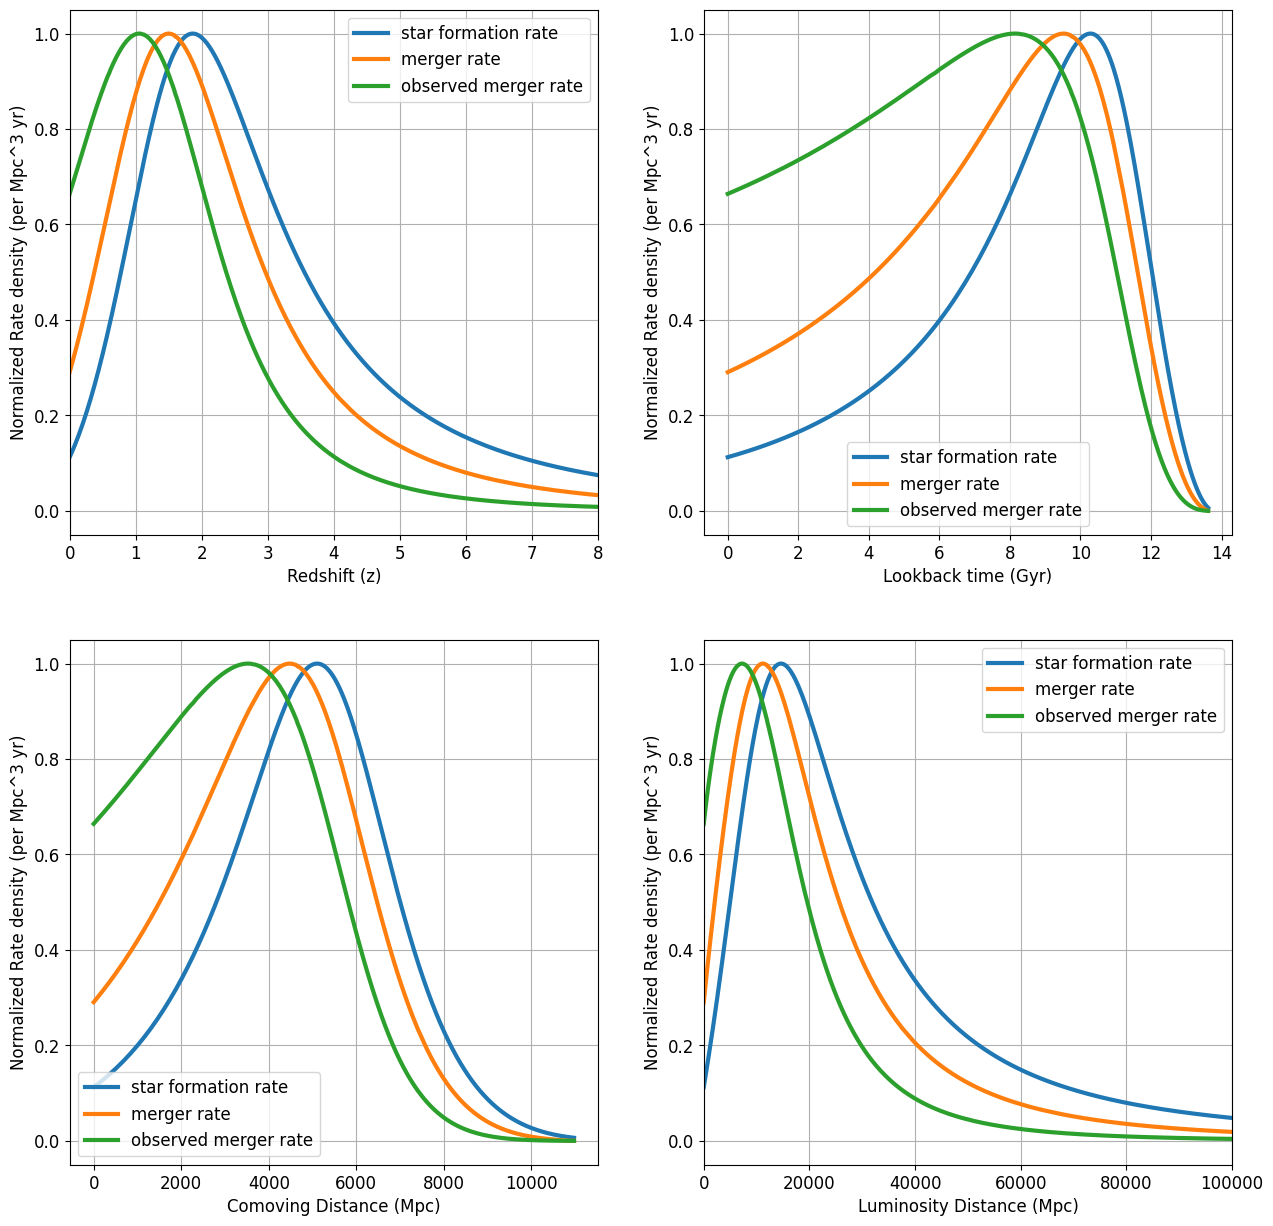

In [21]:
plt.figure(figsize=(15, 15))
for i, d in enumerate(data):
    plt.subplot(2, 2, i+1)
    plt.plot(d, sfr/sfr.max(), label='star formation rate')
    plt.plot(d, mrd/mrd.max(), label='merger rate')
    plt.plot(d, omrd/omrd.max(), label='observed merger rate')
    plt.ylabel('Normalized Rate density (per Mpc^3 yr)')
    plt.xlabel(label[i])
    plt.grid()
    plt.legend()
    if i == 0:
        plt.xlim(0, 8)
    if i == 3:
        plt.xlim(0, 1e5)

# Volume of universe

Mergers are uniform in comoving volume.  Plot comoving volume vs different distance measures

In [22]:
from scipy.integrate import cumulative_trapezoid

In [23]:
dv_dz = 4*np.pi *u.sr * cosmo.differential_comoving_volume(z)
dv_dt = dv_dz / (cosmology.age_at_redshift(0) * cosmo.lookback_time_integrand(z))
dv_ddc = 4*np.pi * dc**2
dv = [dv_dz, dv_dt, dv_ddc]

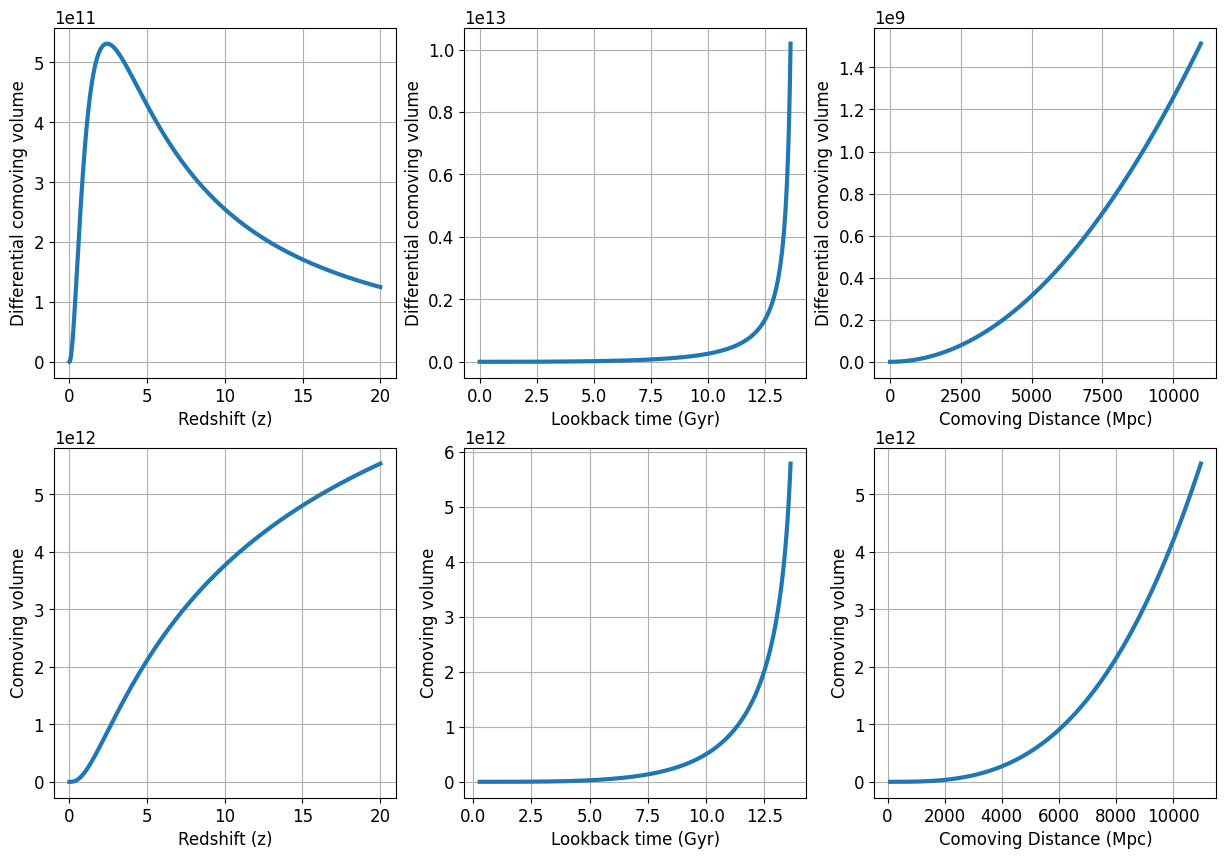

In [24]:
plt.figure(figsize=(15, 10))
for i, d in enumerate(data[:-1]):
    plt.subplot(2, 3, i+1)
    plt.plot(d, dv[i])
    plt.xlabel(label[i])
    plt.ylabel('Differential comoving volume')
    plt.grid()
    
    plt.subplot(2, 3, i+4)
    v = cumulative_trapezoid(dv[i], d)
    plt.plot(d[1:], v)
    plt.xlabel(label[i])
    plt.ylabel('Comoving volume')
    plt.grid()

## Total number of mergers

First, rate vs redshift.  Basically as above but including the volume factors

In [25]:
rate = ([cosmology.rate_at_redshift(zi, sfr = cosmology.sfrMD, z_max = 20) for zi in z])

In [26]:
rate = np.array(rate)

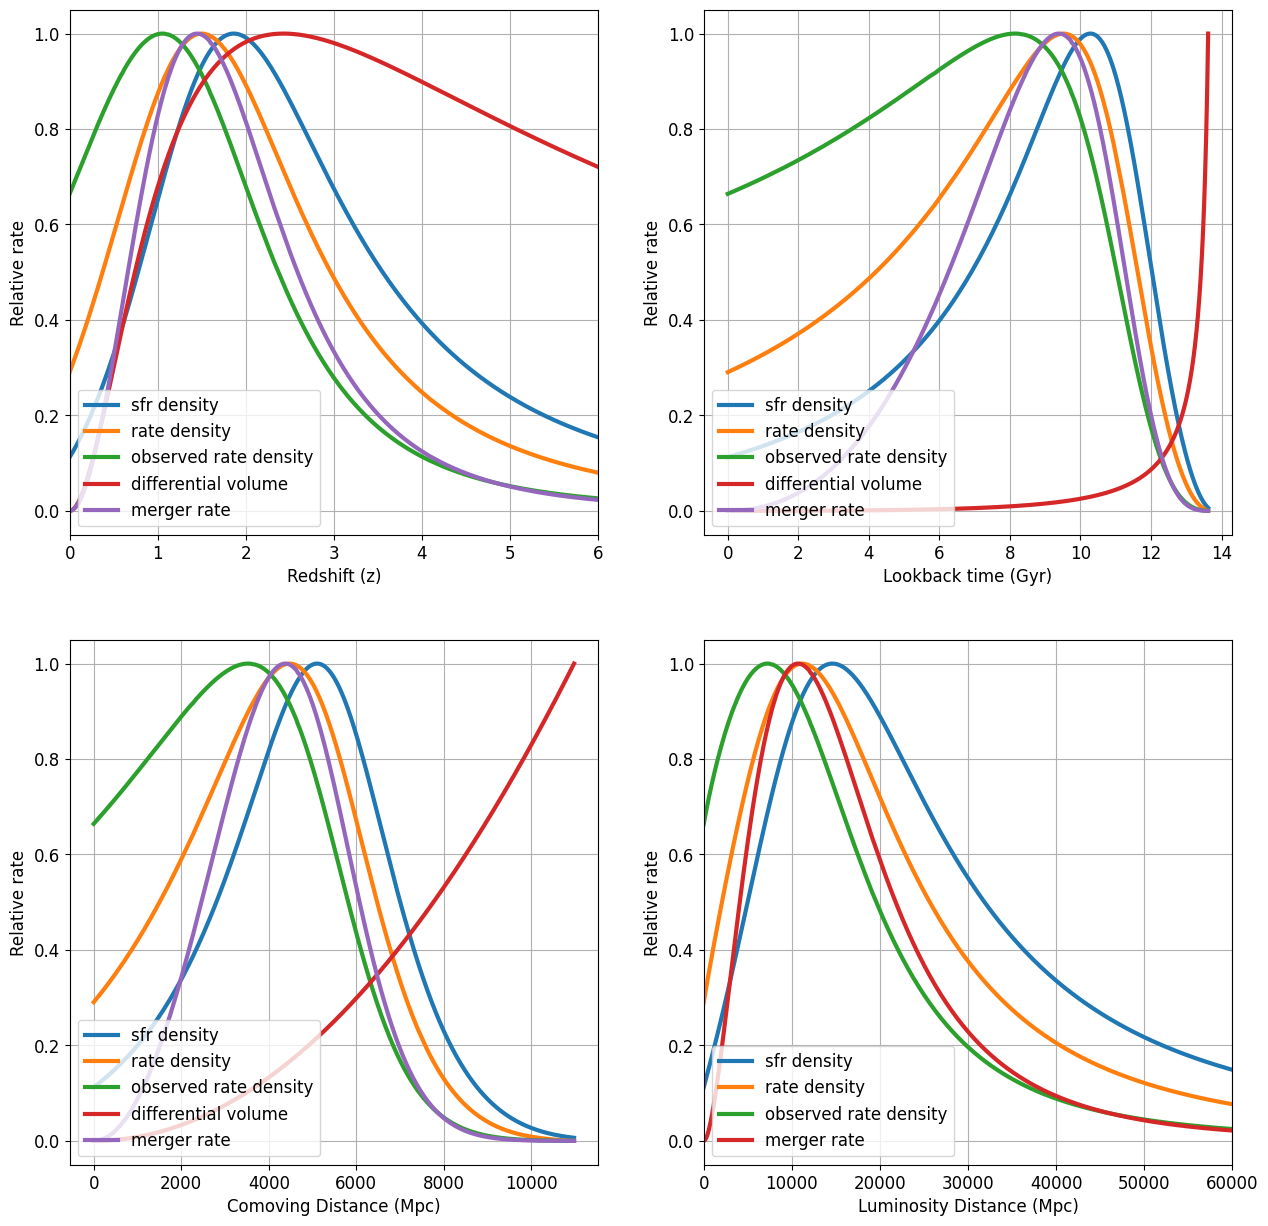

In [27]:
plt.figure(figsize=(15, 15))
for i, d in enumerate(data):
    plt.subplot(2, 2, i+1)
    plt.plot(d, sfr/sfr.max(), label ='sfr density')
    plt.plot(d, mrd/mrd.max(), label ='rate density')
    plt.plot(d, omrd/omrd.max(), label ='observed rate density')
    if i != 3:
        plt.plot(d, dv[i]/dv[i].max(), label = 'differential volume')
    plt.plot(d, rate/rate.max(), label ='merger rate')
    plt.xlabel(label[i])
    plt.ylabel('Relative rate')
    plt.legend(loc='lower left')
    if i==0:
        plt.xlim(0, 6)
    if i==3:
        plt.xlim(0, 6e4)
    plt.grid()


## An alternative distance measure

Add a distance which is comoving distance * (1 + z)^(1/6).  This accounts for GW redshifting

In [28]:
z6 = (1 + z) ** (1./6)
dz = dc * z6

In [29]:
dv_ddz = dv_dz / z6 / (dv_dz / (4 * np.pi * dc**2) + dc / (6 * (1 + z)) )
dv_ddz[0] = 0

/home/divyajyoti/miniconda3/envs/simple-pe-star-formation/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [30]:
d2 = data[:-1]
d2.append(dz)

In [31]:
dv2 = [dv_dz, dv_dt, dv_ddc, dv_ddz]
l2 = ['Redshift (z)', 'Lookback time (Gyr)', 'Comoving Distance (Mpc)', 'Redshifted Distance (Mpc)']

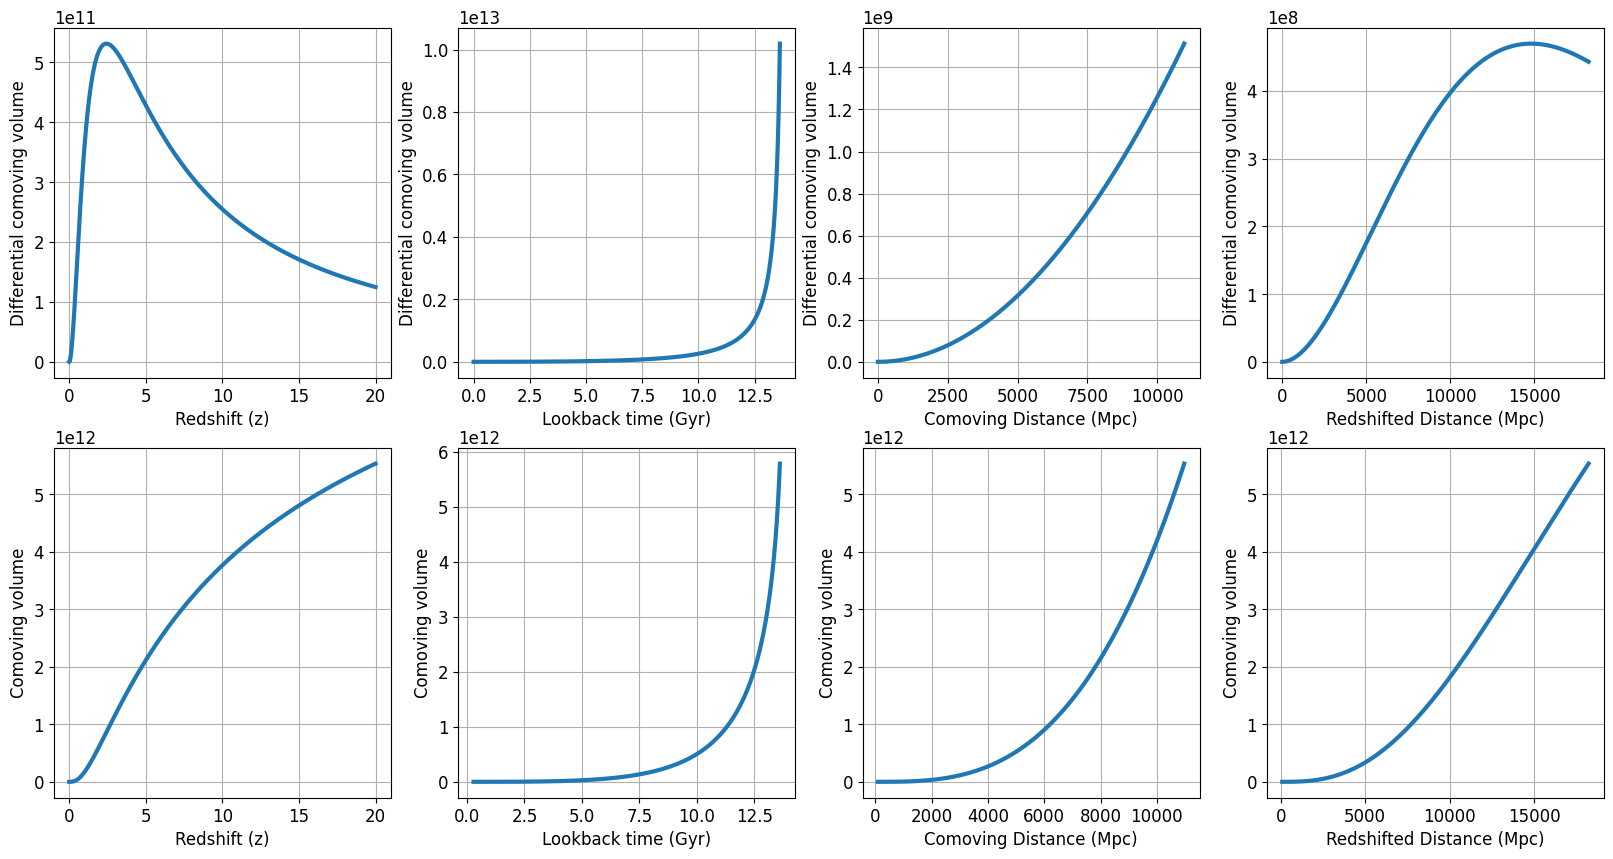

In [32]:
plt.figure(figsize=(20, 10))
for i, d in enumerate(d2):
    plt.subplot(2, 4, i+1)
    plt.plot(d, dv2[i])
    plt.xlabel(l2[i])
    plt.ylabel('Differential comoving volume')
    plt.grid()
    
    plt.subplot(2, 4, i+5)
    v = cumulative_trapezoid(dv2[i], d)
    plt.plot(d[1:], v)
    plt.xlabel(l2[i])
    plt.ylabel('Comoving volume')
    plt.grid()

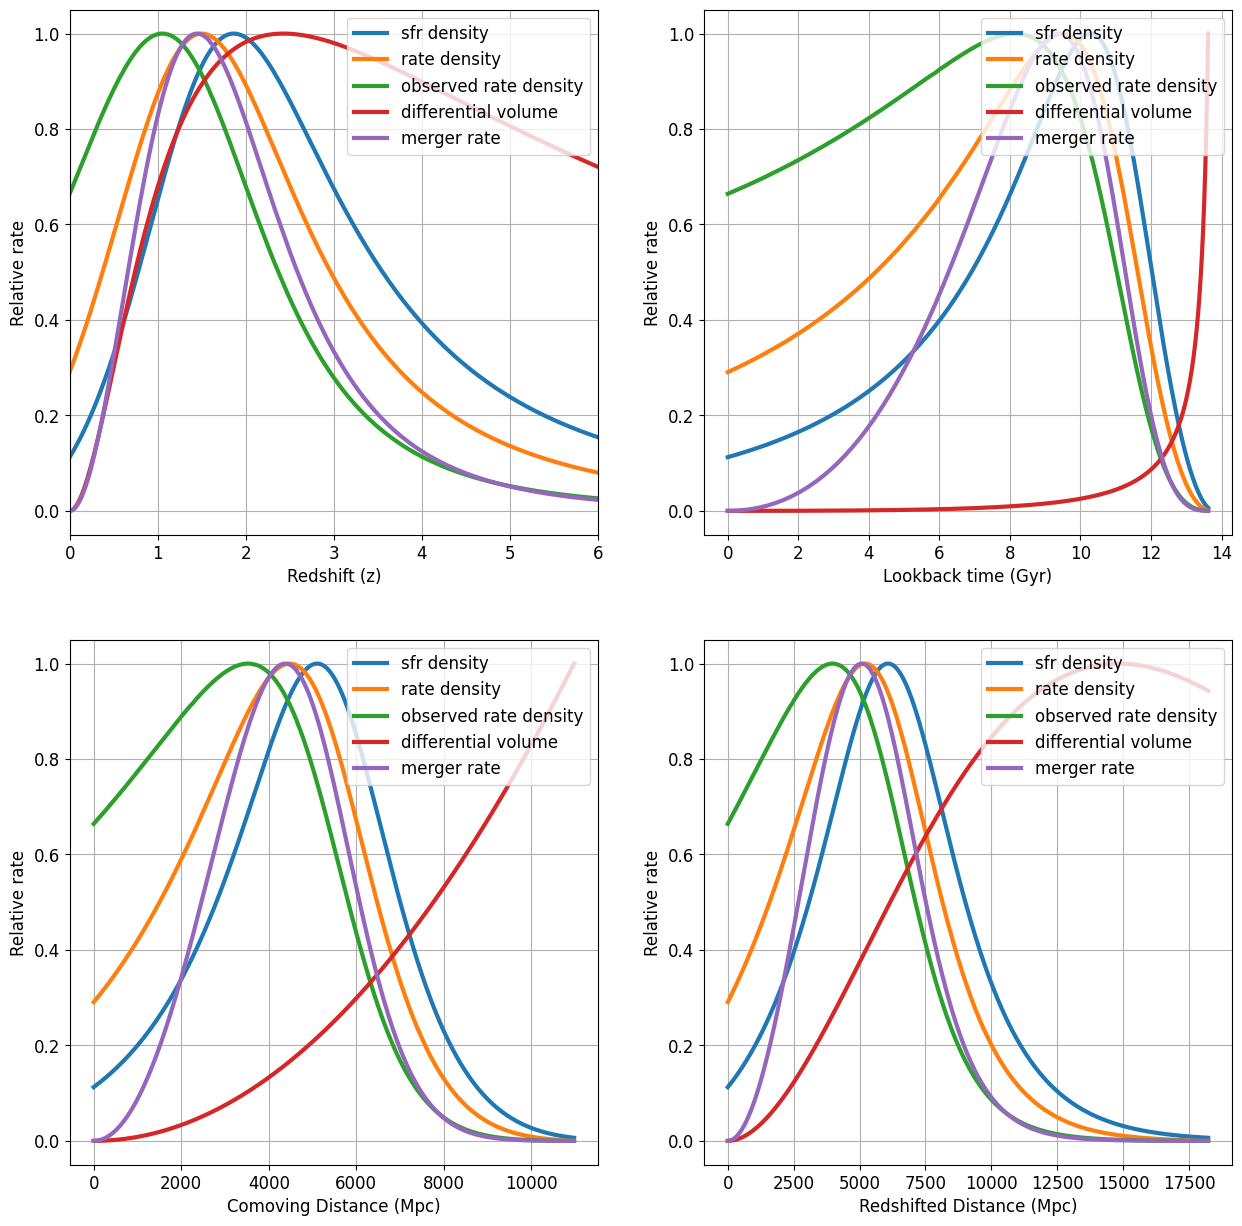

In [33]:
plt.figure(figsize=(15, 15))
for i, d in enumerate(d2):
    plt.subplot(2, 2, i+1)
    plt.plot(d, sfr/sfr.max(), label ='sfr density')
    plt.plot(d, mrd/mrd.max(), label ='rate density')
    plt.plot(d, omrd/omrd.max(), label ='observed rate density')
    plt.plot(d, dv2[i]/dv2[i].max(), label = 'differential volume')
    plt.plot(d, rate/rate.max(), label ='merger rate')
    plt.xlabel(l2[i])
    plt.ylabel('Relative rate')
    plt.legend(loc='upper right')
    if i==0:
        plt.xlim(0, 6)
    plt.grid()


## Total rate

In [34]:
z_max = 20
local_rate_per_gpc = 100

In [35]:
rate_per_year = int(quad(cosmology.rate_at_redshift, 0.001, z_max, args=(local_rate_per_gpc, z_max), epsabs=0, epsrel=1e-3)[0])

In [36]:
print("Assuming a local rate of %d events per Gpc^3 per year, the total rate is %d" % (local_rate_per_gpc, rate_per_year) )

Assuming a local rate of 100 events per Gpc^3 per year, the total rate is 144642
